# Walkthrough 3: Optical barriers  
This notebook runs on Oqtant hardware and uses **1 job** 

## Introduction ##

The next level of control of quantum matter is dynamically altering the potential energy as a function of position during the manipulation phase.  In Oqtant, this is accomplished by applying far-blue-detuned light fields to the atom ensemble.  This "painted" light represents a *repulsive* potential energy to the atoms via the AC Stark shift.  The spatially-dependent potential energy depends on the local intensity of the light field. Dynamic control of the local intensity alters the potential energy landscape in which the atoms are trapped. 

OqtAPI users have control of this light field by creating and manipulating one or more `Barrier` objects, which are superimposed on the background magnetic potential that traps the atoms.  Other abstracted optical objects are also supported and will be the topic of future walkthroughs.  

In this walkthrough, we will explore application of quasi-1D optical barriers on Oqtant's cigar-shaped atomic ensembles.  Users have control over the dynamic position (in microns), width (in microns), energetic height (in kHz), and shape of the barrier objects painted along the long dimension of the ensemble.  The effective 1D potential is achieved by quickly rastering/scanning the applied light along one short axis, while the light propagates along the other short axis.  

Application of these barriers allows for the ensemble to be split, recombined, swept to one side, or any number of other desired manipulations.  Such manipulations are the building blocks for constructing atomtronic circuits, exploring interference and tunneling, studying quantum dynamics, or developing quantum sensors.    


This, along with all our example notebooks are publicly available for download from our [GitLab repository.](https://gitlab.com/infleqtion/albert/oqtant-documentation/-/tree/main/oqtant_documentation/docs/examples?ref_type=heads)

### Imports and user authentication ###

In [1]:
from oqtant.schemas.quantum_matter import QuantumMatterFactory

qmf = QuantumMatterFactory()
qmf.get_login()

Auth(children=(HBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x12\x00\x00\x00\xc…

In [3]:
qmf.get_client()

Job Limits:
╒══════════════╤═══════════════════╤═══════════════╤═══════════════════════╕
│   Daily Used │   Daily Remaining │   Daily Limit │   Purchased Remaining │
╞══════════════╪═══════════════════╪═══════════════╪═══════════════════════╡
│            0 │              1000 │          1000 │                  1000 │
╘══════════════╧═══════════════════╧═══════════════╧═══════════════════════╛


## Barrier objects  ##

Barriers are included in *matter* by passing a list of `Barrier` (*barrier*) objects during creation by the factory.  Let us first explore *barrier* objects themselves. 

### Create a Barrier object ###

Create a Gaussian-shaped *barrier* centered at a position of 10 (microns) with an energetic height of 30 (kHz) and a width of 3 (microns).  Here, a position of 0 corresponds to the geometric center of the atom ensemble along the long dimension.  Let us plan on having a lifetime of 10 ms for the manipulation phase of our *matter* object, with our barrier being applied starting at t = 2.5 ms after the end of RF evaporation, and lasting until t = 7.5 ms. This represents a barrier lifetime of 5 ms. We create *barrier* objects by providing equal length lists of barrier parameters at specified times, as follows:  

In [4]:
barrier = qmf.create_barrier(
    positions=[10, 10],
    heights=[30, 30],
    widths=[3, 3],
    times=[2.5, 7.5],
    shape="GAUSSIAN",
)

### Visualize a Barrier object at fixed times ###

What does our created *barrier* look like?  We can use the `Barrier.show_potential()` method to find out.  This method accepts a list of times for which to plot the position-dependent potential energy represented by the *barrier*:

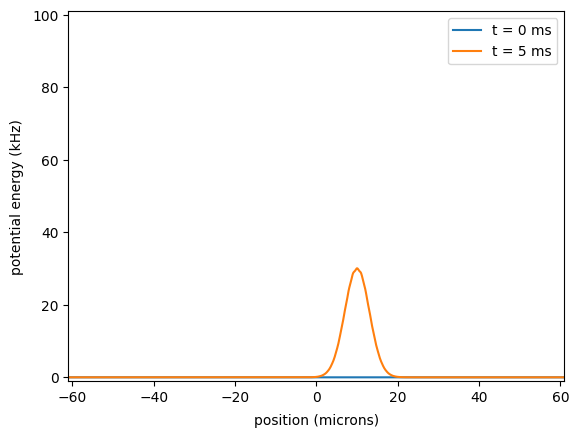

In [5]:
barrier.show_potential(times=[0, 5])

We can see that at t = 0, our barrier hasn't been "born" yet, and the potential energy is zero everywhere.  However,  at t = 5 our barrier is now present (and will remain present until the end of its lifetime at t = 7.5). 

The plot above includes effects from the hardware implementation of the optical barriers realized by the Oqtant hardware, which are discussed in more detail below.  These effects are due to:

- The optical projection system that creates barriers has finite resolution
- Barrier parameters like position, width, and height are updated periodically every 100 microseconds rather than continuously
- Barriers are implemented as a linear superposition of Gaussian spots over a fixed grid of positions with dynamic/variable weights

If you want to explore the differences between the potential actually produced in the hardware and that specified by a user-created Barrier object (the so-called "ideal" potential), you can pass the optional parameter `include_ideal=True` to the show_potential() method.  You can also customize the region of interest by providing `xlimits` and `ylimits` lists:

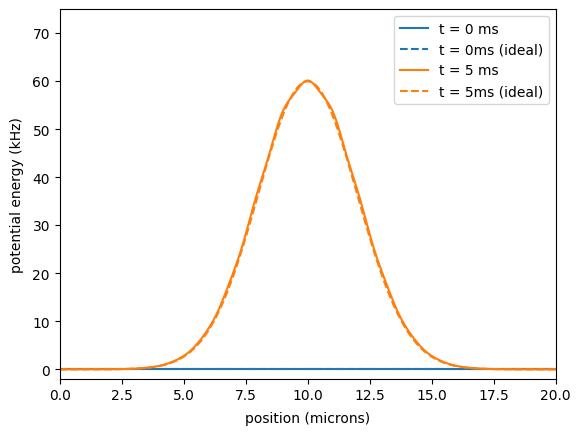

In [5]:
barrier.show_potential(
    times=[0, 5], include_ideal=True, xlimits=[0, 20], ylimits=[-2, 75]
)

Access potential data using `Barrier.get_potential()` and `Barrier.get_ideal_potential()` methods, both of which accept a *time* parameter and list of *positions* where the potential should be evaluated:

In [6]:
import numpy as np

positions = np.arange(0.0, 20.0, 1.0)
print(barrier.get_potential(time=5, positions=positions))
print(barrier.get_ideal_potential(time=5, positions=positions))

[0.00026677033899466133, 0.002774241354477191, 0.022568757418243737, 0.1436793891264772, 0.7157720763332929, 2.7887787214287743, 8.49001705081762, 20.172539909271105, 37.36562418011505, 53.812691833210096, 60.189934925264936, 53.869815993029306, 37.40827542422607, 20.19731465682421, 8.505292314202556, 2.797207111919479, 0.7193173127719182, 0.14476249397309685, 0.022808651531133345, 0.0028130889793505256]
[0.00022359919032472026, 0.0024039178435770643, 0.02012775767415071, 0.1312494670909731, 0.6665397922945384, 2.636216017404445, 8.120116994196762, 19.479148041500984, 36.391839582758, 52.94981415507573, 60.0, 52.94981415507573, 36.391839582758, 19.479148041500984, 8.120116994196762, 2.636216017404445, 0.6665397922945384, 0.1312494670909731, 0.02012775767415071, 0.0024039178435770643]


### Visualize barrier dynamics ###

We can also view each *barrier*'s dynamics over the time of the manipulation phase:

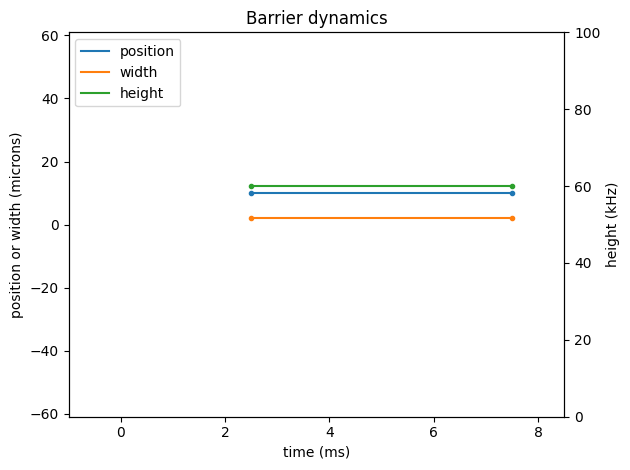

In [7]:
barrier.show_dynamics()

We see the constructed values (of position, width, and height) for times between our barrier's "birth" (at t = 2.5) and its "death" (at t = 7.5).  Outside of its lifetime, this barrier will not exist (no light will be projected onto the atoms, at least from this particular barrier).  

### Script barrier behavior ###

So far, our barrier is *static*, i.e. its position, width, and height are all constants during its lifetime.  If we want to add some dynamics to the barrier, we can either pass the desired times/positions/heights/widths as full lists when creating the barrier or, alternatively, make use of the `Barrier.evolve()` method, which allows us to generically script a barrier's behavior in time.    

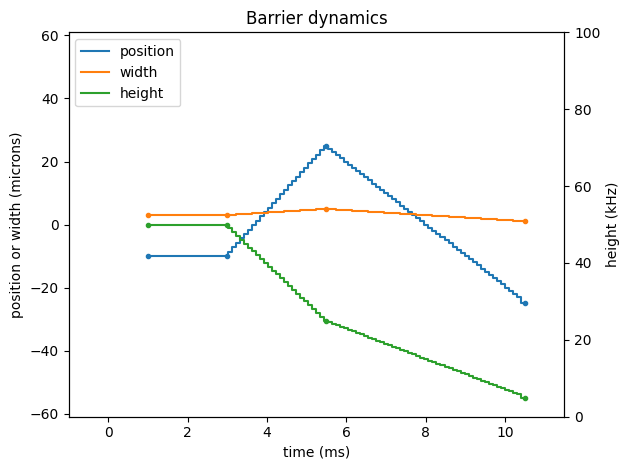

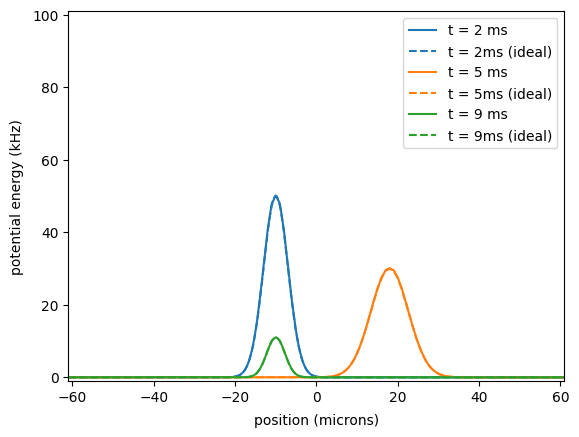

In [8]:
# start with a static barrier held on for some time
barrier = qmf.create_barrier(
    positions=[-10, -10],
    heights=[50, 50],
    widths=[3, 3],
    times=[1, 3],
    shape="GAUSSIAN",
)

# add dynamics, automatically increasing the barrier lifetime
barrier.evolve(duration=2.5, position=25, height=25, width=5)

# and more dynamics after that
barrier.evolve(duration=5, position=-25, height=5, width=1)

# show the barrier at the following times, along with the overall dynamics
barrier.show_dynamics()
barrier.show_potential(times=[2, 5, 9], include_ideal=True)

We now have a highly dynamic barrier whose position, height, and width change over the course of its lifetime.  The "stepwise" nature of the barrier parameters in time is a result of the finite update period of Oqtant's optical projection system (100 microseconds).  This behavior is most obvious for barrier parameters that change significantly over short time periods.    

*NOTE: Any parameters that are to remain unchanged during a scripted evolution step can be omitted from the call to `Barrier.evolve()`. *   

*NOTE: A barrier object's shape is not dynamically controllable.  However, such behavior is supported by so-called `Landscape` objects, introduced in the following walkthrough.*

*NOTE: A barrier object's lifetime will automatically be extended by the duration parameter passed to the `Barrier.evolve()` method. * 

### Available Barrier shapes ###

Supported Barrier shape options include GAUSSIAN, SQUARE, and LORENTZIAN.  In all three cases, the width parameter means something slightly different, but for consistency generally refers to the appropriate *half width* of the functional form.  The below table summarizes the potential energy ($U(x)$) as a function of position ($x$), barrier height $h$ , position $x_0$, and width $w$, for the currently supported barrier shapes:

| specified shape | $U(x)$ functional form | width ($w$) interpretation               |
|-----------------|---------------------------------------------|---------------------|
| GAUSSIAN        | $ h e^{-\frac{(x - x_0)^2}{2 w^2}} $        | gaussian width      |
| LORENTZIAN      | $ \frac{h}{1 + (x - x_0)^{2} / w^{2}} $     | half-width half-max |
| SQUARE          | $h$ if $abs(x-x_0) \leq w$, else $0$        | half width            |


Create *barrier* objects of different shapes:

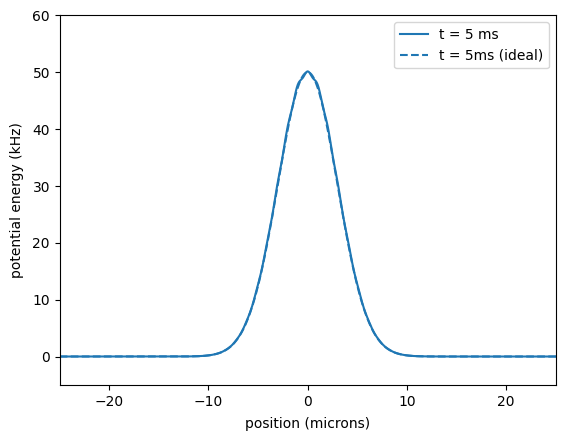

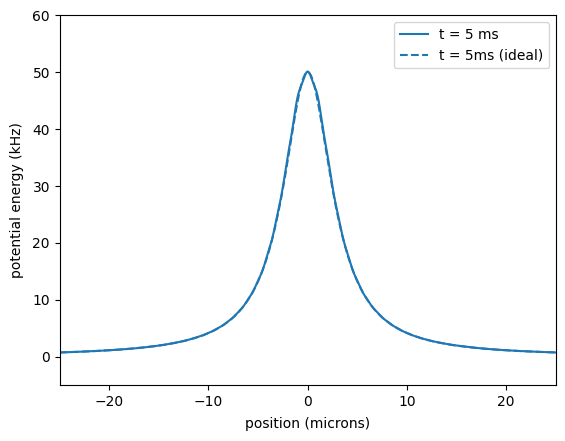

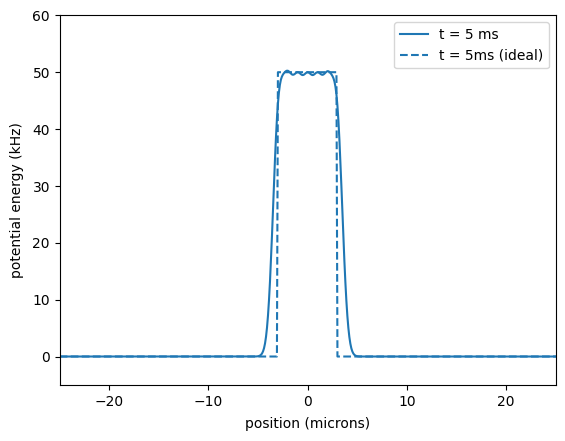

In [6]:
shapes = ["GAUSSIAN", "LORENTZIAN", "SQUARE"]
for shape in shapes:
    barrier = qmf.create_barrier(
        positions=[0, 0],
        heights=[50, 50],
        widths=[3, 3],
        shape=shape,
        times=[0, 10],  # this is the default
    )
    barrier.show_potential([5], include_ideal=True, xlimits=[-25, 25], ylimits=[-5, 60])

## Add Barriers to QuantumMatter objects ##

### Instantiation ###

Add one or more *barrier* objects to a *matter* object by passing a list with the `barriers` input parameter during instantiation

In [10]:
# define the first barrier, with initial hold + evolution
barrier1 = qmf.create_barrier(
    positions=[10, 10],
    heights=[30, 30],
    widths=[3, 3],
    times=[2.5, 7.5],
    shape="GAUSSIAN",
)
barrier1.evolve(duration=2, position=20, height=20, width=5)

# and a second one, also with initial hold + evolution
barrier2 = qmf.create_barrier(
    positions=[-10, -10],
    heights=[30, 30],
    widths=[3, 3],
    times=[2.5, 10],
    shape="SQUARE",
)
barrier2.evolve(duration=4, position=-25, height=5, width=5)

# and construct the desired QuantumMatter object
matter = qmf.create_quantum_matter(
    temperature=100,
    lifetime=15,
    time_of_flight=10,
    barriers=[barrier1, barrier2],
    name="Now with barriers!",
)

### Visualize multi-barrier dynamics of the QuantumMatter object ###

The dynamics of all *barrier* objects in a *matter* object can be visualized simultaneously using the `QuantumMatter.show_barrier_dynamics()` method:  

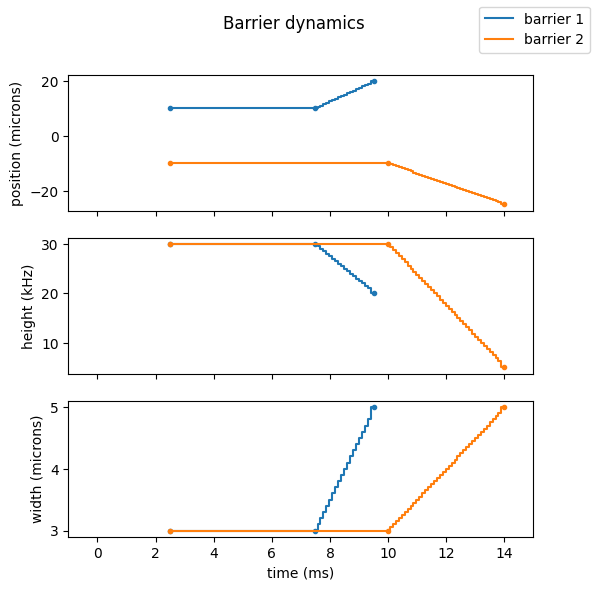

In [11]:
matter.show_barrier_dynamics()

### Visualize the total potential energy ###

Visualize the overall *total* spatial energy profile at specific times in the manipulation phase, including contributions from both the (magnetic) trapping potential as well as the (optical) barrier contributions, using the `QuantumMatter.show_potential()` method. This method accepts a list of times for which to plot the potential energy:

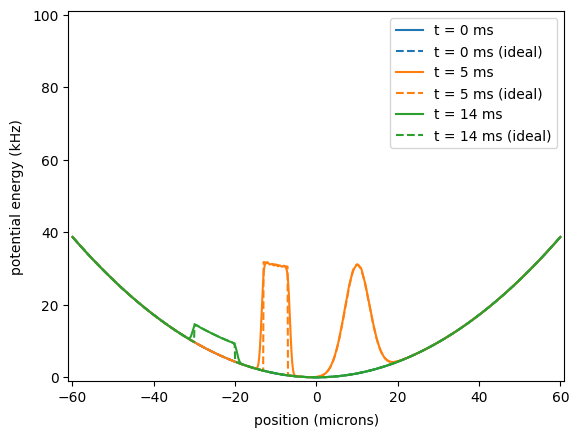

In [12]:
matter.show_potential(times=[0, 5, 14], include_ideal=True)

As we can see, at t = 0 the potential energy profile is identical to the purely-magnetic trapping potential seen in the last walkthrough as no barriers have yet been created.  At t = 5, we have two barriers of different shapes centered at +/- 10 microns, superimposed onto the background magnetic trapping potential.  At t = 14 ms, barrier 1 has completed its lifetime and is no longer present, leaving only barrier 2, which by that time has shifted over to a position of -25, increased its width, and reduced its height.  

WARNING: The total *optical* potential energy at a single position is limited to be 100 kHz in the current hardware implementation.  Tall barriers that are close enough to spatially overlap can encounter this limit.  

If you wish to not include the magnetic potential in the visualization, you can pass the `include_magnetic=False` option:

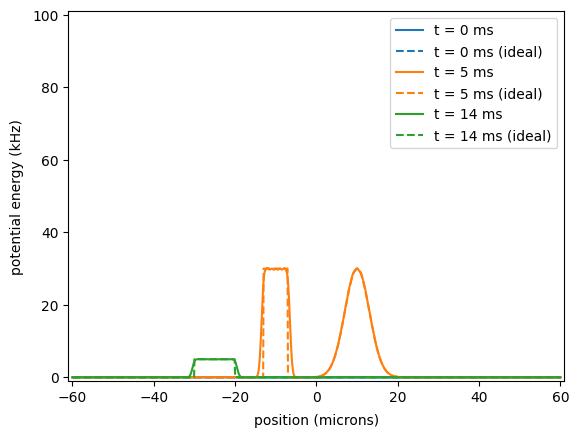

In [13]:
matter.show_potential(times=[0, 5, 14], include_magnetic=False, include_ideal=True)

## In-trap imaging ##

In addition to time-of-flight imaging, where the atom ensemble is released from the magnetic trapping potential some time before the image of the atoms is taken, Oqtant also supports the option to take the image of the atoms *in-trap*.  This option allows for direct imaging of atom ensembles that are swept, split, or shifted, while or shortly after barriers are being applied.  These manipulations can act as the basis for studying quantum dynamics, atomtronics, and developing quantum sensors.  In-trap imaging allows images of the atoms to be taken during these manipulations.

NOTE: While in-trap imaging is useful for revealing the spatial distribution of atoms within the ensemble at the time they are imaged, it is less useful for extracting quantitative information such as temperature, condensed fraction, etc.  Hence, these calculations are not done when this imaging option is specified. 

In [14]:
# create a simple static barrier
barrier = qmf.create_barrier(
    positions=[-10, -10],
    heights=[30, 30],
    widths=[3, 3],
    shape="GAUSSIAN",
    times=[2.5, 10],
)

# and QuantumMatter with a lifetime so that the barrier exists right up to the end
matter = qmf.create_quantum_matter(
    temperature=100,
    lifetime=barrier.death,
    barriers=[barrier],
    image="IN_TRAP",  # take an in-trap image, time_of_flight input parameter is not relevant in this case
    note="in-trap imaging with barrier",
)

matter.submit(track=True)

Submitting 1 job(s):

- Job: quantum matter
  Job ID: 366b3219-edbd-44af-be3d-1890b1864801


The output data for jobs that use in-trap imaging is different than those that use time of flight imaging:

In [20]:
matter.get_result()
matter.status

'COMPLETE'

In [21]:
matter.output.fields

- it_plot
  - pixels
  - rows
  - columns
  - pixcal


As discussed above, no temperature or ensemble population calculations are done in this case.  Instead, the output is the OD image, which can be viewed as follows:

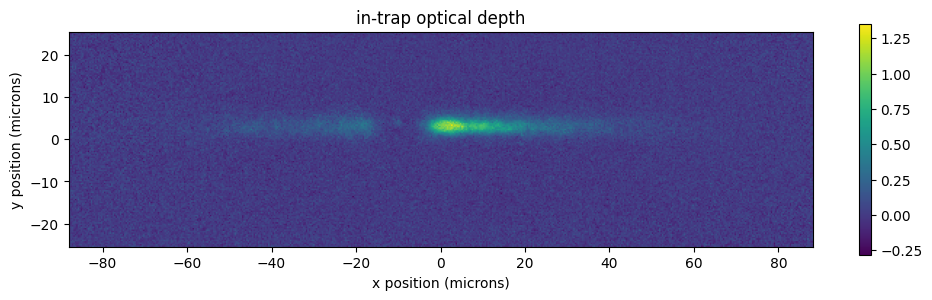

In [22]:
matter.output.plot_it()

## Advanced topics and discussion ##

### Hardware implementation limits and effects ###

In order to understand some of the features and limitations of Oqtant's painted potential capabilities, it is important to understand the implementation of *how* these light fields are painted on the atoms.  

 

#### Finite projection system resolution and the fixed-grid approach ####

Along the long axis of the produced quantum matter, i.e. the weak axis of the trapped BEC, light can be applied to any particular position by diffracting it.  A single diffracted laser beam forms a Gaussian-shaped "spot" on the quantum matter that (because the light is blue-detuned from the atomic resonance) introduces a repulsive potential energy for the atoms proportional to the local light intensity.  The Oqtant hardware that diffracts the light, called the projection system, has finite resolution, resulting in a spot with non-zero size -- in the current Oqtant hardware this spot has a 1/$e^{2}$ diameter of 2.2 microns.  Optical potential fields, including the *barrier* objects explored above with their adjustable parameters, are formed by summing many of these spots, each with a fixed position but dynamic amplitude/intensity, together.  In the current hardware implementation, the step size of this grid is 1 micron.  The plot below demonstrates how a constituent *barrier* object can be created using this approach of summing independent spots, all of the same fixed width but variable amplitude, together. 

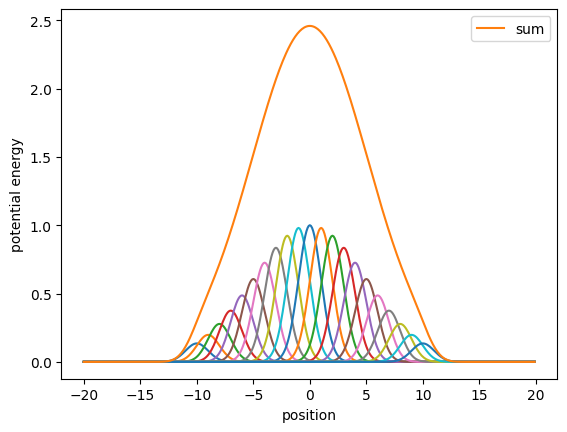

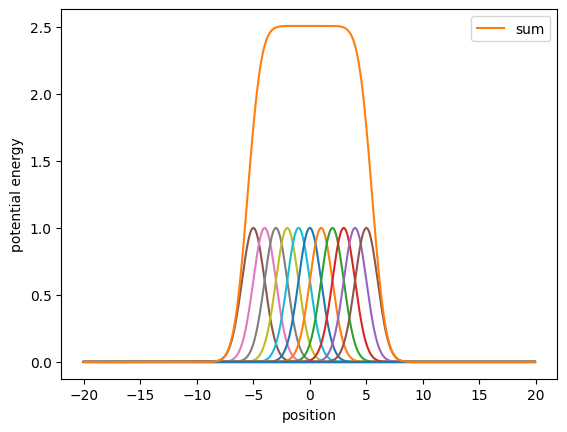

In [25]:
from bert_schemas.projected import gaussian
import numpy as np
import matplotlib.pyplot as plt

spots = np.arange(-10, 11, 1, dtype=float)  # individual Gaussian spot centers
positions = np.arange(-20, 20, 0.1)


def show_contributions_and_sum(amplitudes):
    fig, ax = plt.subplots()
    total_potential = np.zeros_like(positions)
    for indx, a in enumerate(amplitudes):
        addition = np.asarray(
            gaussian(xs=positions, amp=a, center=spots[indx], sigma=1, offset=0)
        )
        plt.plot(positions, addition)
        total_potential += addition
    (ln,) = plt.plot(positions, total_potential)
    plt.legend([ln], ["sum"], loc=0)
    plt.xlabel("position")
    plt.ylabel("potential energy")
    plt.show()


# Sum individual contributions to obtain a larger GAUSSIAN barrier
amplitudes = np.asarray(
    gaussian(xs=spots, amp=1, center=0, sigma=5, offset=0)
)  # example amplitudes for each spot
show_contributions_and_sum(amplitudes)

# Sum individual contributions to obtain a SQUARE barrier
amplitudes = np.asarray(
    [1 if abs(spot) < 6 else 0 for spot in spots]
)  # example amplitudes for each spot
show_contributions_and_sum(amplitudes)

#### Periodic updates and rastering of the painted light in the short atom ensemble dimension ####

Furthermore, as seen above when inspecting the dyanmics of Barrier parameters, the properties of the projected light are updated periodically on a 100 microsecond period. All Barrier dynamics and dynamics of any painted light features exhibit discrete jumps as properties are periodically updated.  We saw this behavior above when inspecting the *dynamics* of Barrier object parameters.  

Along the narrow axis of the quantum matter, the Gaussian spots are rastered quickly to achieve a quasi-1D potential energy.  Generally, it is wise to keep the update timescales fast compared to the dynamics of the atoms in the trap.  In the case of Oqtant, the magnetic trapping frequencies are approximately 40 Hz along the weak axis and 400 Hz along the strong axes.  The short update period of light features and fast (20 kHz) raster rate ensure, under most circumstances, that the atoms only experience the *average* of the applied light field.  

#### Consequences ####

The consequences of these implementation choices, and the fact that the spatial grid size is finer than the resolution of the projection system, include

1. The light diffracted to one spot on the grid contains contributions from nearby spots
2. Very narrow barriers with dynamic widths will exhibit discontinuous jumps in width as additional spot positions are included or excluded.
3. Very narrow barriers that are scanned in position could vary in height as the barrier center/peak alternates between integer and intra-integer values.  

The algorithms implemented in Oqtant's projection system are designed to minimize these potentially unwanted effects, though item (2) above is still present in the current system.  One consequence of the above is that the narrowest possible Barriers are created by specifying a SQUARE barrier of minimal width (currently 0.5 microns) with an integer position.  The resulting Barrier object will consist of only a single diffracted spot, and will in reality be gaussian rather than square, realizing the smallest possible feature projected by the Oqtant hardware.